# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups      
Sample_017  Q12841;Q12841-2        17.827
Sample_075  Q8N475;Q8N475-2        14.415
Sample_068  Q562R1                 19.135
Sample_064  P43652                 18.876
Sample_037  F5GY80;F5H7G1;P07358   19.358
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups                      
Sample_162  E9PHN6;E9PHN7;F6XZQ7;P28161;P28161-2   13.280
Sample_163  Q5JRA6;Q5JRA6-2                        15.523
Sample_171  B1AKZ9;B1AL00;P18075                   11.169
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.040
            A0A075B6Q5                 11.510
            A0A075B6R2                 13.398
            A0A075B6S5                 13.170
            A0A087WSY4                 13.008
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.529
            Q9UI40;Q9UI40-2            12.512
            Q9UIW2                     12.332
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.099
            Q9UP79                     12.511
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.239,15.050,16.842,19.863,15.971,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.672,19.067,...,15.528,15.576,14.078,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.911,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.515,17.705,17.039,15.911,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.505,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.304,15.345,17.084,18.708,14.249,19.433,11.475,10.984
Sample_207,15.739,16.877,15.469,16.898,15.119,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,14.040,...,16.012,15.178,12.091,15.050,16.842,19.863,12.053,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.465,19.067,16.188,...,15.528,15.576,12.538,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.797,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.458,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.201,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.764,15.345,17.084,18.708,14.249,19.433,12.335,13.982
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 391.73it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.33it/s]

100%|██████████| 2/2 [00:00<00:00,  6.30it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.75it/s]

100%|██████████| 3/3 [00:00<00:00,  4.52it/s]

100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.71it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.75it/s]

100%|██████████| 4/4 [00:01<00:00,  3.60it/s]

100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.50it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.16it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.29it/s]

100%|██████████| 5/5 [00:01<00:00,  2.84it/s]

100%|██████████| 5/5 [00:01<00:00,  3.28it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.82it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.00it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.18it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.90it/s]

100%|██████████| 6/6 [00:01<00:00,  2.73it/s]

100%|██████████| 6/6 [00:01<00:00,  3.09it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.65it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.64it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.18it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.93it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.90it/s]

100%|██████████| 7/7 [00:02<00:00,  2.87it/s]

100%|██████████| 7/7 [00:02<00:00,  3.08it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.60it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.40it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.05it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.92it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.84it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.84it/s]

100%|██████████| 8/8 [00:02<00:00,  2.61it/s]

100%|██████████| 8/8 [00:02<00:00,  2.89it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:02,  3.49it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.50it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.24it/s]

 56%|█████▌    | 5/9 [00:02<00:01,  2.41it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.38it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.33it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.23it/s]

100%|██████████| 9/9 [00:03<00:00,  2.36it/s]

100%|██████████| 9/9 [00:03<00:00,  2.40it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.42it/s]

 30%|███       | 3/10 [00:01<00:02,  2.46it/s]

 40%|████      | 4/10 [00:01<00:02,  2.16it/s]

 50%|█████     | 5/10 [00:02<00:02,  2.11it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.28it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.42it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.51it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.62it/s]

100%|██████████| 10/10 [00:03<00:00,  2.69it/s]

100%|██████████| 10/10 [00:04<00:00,  2.50it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.10it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.62it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.92it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.67it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.65it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.54it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.72it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.88it/s]

 91%|█████████ | 10/11 [00:03<00:00,  3.07it/s]

100%|██████████| 11/11 [00:03<00:00,  3.34it/s]

100%|██████████| 11/11 [00:03<00:00,  3.10it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.47it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.03it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.31it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.83it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.62it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.30it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.31it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.46it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.61it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.72it/s]

100%|██████████| 12/12 [00:04<00:00,  2.91it/s]

100%|██████████| 12/12 [00:04<00:00,  2.90it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.94it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.14it/s]

 31%|███       | 4/13 [00:01<00:02,  3.19it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.78it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.65it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.63it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.62it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.29it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.02it/s]

 85%|████████▍ | 11/13 [00:04<00:01,  1.91it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.85it/s]

100%|██████████| 13/13 [00:05<00:00,  2.02it/s]

100%|██████████| 13/13 [00:05<00:00,  2.37it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.43it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.47it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.25it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.11it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.03it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.18it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.02it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.06it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.07it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.77it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.47it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.12it/s]

100%|██████████| 14/14 [00:05<00:00,  1.95it/s]

100%|██████████| 14/14 [00:05<00:00,  2.63it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  6.55it/s]

 20%|██        | 3/15 [00:00<00:03,  3.58it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.01it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.53it/s]

 40%|████      | 6/15 [00:02<00:03,  2.41it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.59it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.51it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.54it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.65it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.63it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.70it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.47it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.25it/s]

100%|██████████| 15/15 [00:05<00:00,  2.15it/s]

100%|██████████| 15/15 [00:05<00:00,  2.54it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.003      0.058 0.019          0.687 0.393       0.100   
2             0.005 0.003      0.062 0.029          0.632 0.146       0.457   
3             0.005 0.003      0.057 0.020          0.798 0.079       0.713   
4             0.005 0.003      0.054 0.016          0.804 0.078       0.767   
5             0.004 0.003      0.048 0.004          0.828 0.081       0.793   
6             0.004 0.000      0.051 0.014          0.825 0.087       0.790   
7             0.004 0.002      0.052 0.010          0.829 0.074       0.836   
8             0.005 0.004      0.067 0.031          0.828 0.077       0.830   
9             0.005 0.004      0.068 0.026          0.832 0.076       0.823   
10            0.005 0.003      0.050 0.012          0.832 0.075       0.822   
11            0.005 0.003      0.053 0.017          0.842 0.079       0.808   
12            0.004 0.002      0.051 0.014          0.840 0.078       0.806   
13            0.005 0.003      0.055 0.019          0.829 0.084       0.806   
14            0.006 0.005      0.069 0.029          0.822 0.088       0.793   
15            0.006 0.004      0.063 0.021          0.819 0.086       0.786   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.085   0.168 0.130                  0.542 0.042        0.846   
2          0.113   0.519 0.097                  0.624 0.066        0.698   
3          0.105   0.747 0.069                  0.789 0.055        0.896   
4          0.109   0.780 0.071                  0.814 0.059        0.904   
5          0.096   0.806 0.065                  0.834 0.055        0.910   
6          0.094   0.803 0.066                  0.831 0.057        0.909   
7          0.101   0.829 0.068                  0.854 0.059        0.921   
8          0.102   0.825 0.071                  0.851 0.061        0.918   
9          0.100   0.824 0.068                  0.850 0.059        0.919   
10         0.100   0.823 0.068                  0.850 0.058        0.918   
11         0.096   0.821 0.069                  0.848 0.058        0.924   
12         0.097   0.819 0.067                  0.846 0.057        0.922   
13         0.100   0.813 0.069                  0.841 0.059        0.919   
14         0.103   0.802 0.074                  0.832 0.061        0.917   
15         0.103   0.797 0.072                  0.828 0.060        0.916   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.821 0.088        210.000 0.000  
2          0.083                  0.652 0.098        210.000 0.000  
3          0.044                  0.871 0.057        210.000 0.000  
4          0.045                  0.882 0.055        210.000 0.000  
5          0.047                  0.894 0.054        210.000 0.000  
6          0.048                  0.894 0.056        210.000 0.000  
7          0.043                  0.911 0.045        210.000 0.000  
8          0.045                  0.906 0.049        210.000 0.000  
9          0.045                  0.908 0.049        210.000 0.000  
10         0.044                  0.908 0.048        210.000 0.000  
11         0.046                  0.915 0.049        210.000 0.000  
12         0.047                  0.913 0.049        210.000 0.000  
13         0.048                  0.910 0.049        210.000 0.000  
14         0.048                  0.909 0.049        210.000 0.000  
15         0.048                  0.907 0.048 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 453.10it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.24it/s]

100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  2.95it/s]

100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

100%|██████████| 3/3 [00:01<00:00,  2.33it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  2.68it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  1.87it/s]

100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:01,  2.70it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.98it/s]

 80%|████████  | 4/5 [00:02<00:00,  1.69it/s]

100%|██████████| 5/5 [00:02<00:00,  1.71it/s]

100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.77it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.83it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.08it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  1.80it/s]

100%|██████████| 6/6 [00:03<00:00,  1.65it/s]

100%|██████████| 6/6 [00:03<00:00,  1.97it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.92it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.42it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.15it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.02it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.14it/s]

100%|██████████| 7/7 [00:03<00:00,  1.93it/s]

100%|██████████| 7/7 [00:03<00:00,  2.13it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.72it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.95it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.68it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.25it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.06it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.05it/s]

100%|██████████| 8/8 [00:03<00:00,  2.20it/s]

100%|██████████| 8/8 [00:03<00:00,  2.42it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.35it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.70it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.23it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.02it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.36it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.08it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  1.95it/s]

100%|██████████| 9/9 [00:03<00:00,  2.08it/s]

100%|██████████| 9/9 [00:03<00:00,  2.41it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.17it/s]

 30%|███       | 3/10 [00:00<00:01,  3.58it/s]

 40%|████      | 4/10 [00:01<00:02,  2.98it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.81it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.28it/s]

 70%|███████   | 7/10 [00:02<00:01,  1.99it/s]

 80%|████████  | 8/10 [00:03<00:01,  1.85it/s]

 90%|█████████ | 9/10 [00:03<00:00,  1.93it/s]

100%|██████████| 10/10 [00:04<00:00,  1.99it/s]

100%|██████████| 10/10 [00:04<00:00,  2.27it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.56it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.09it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.88it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.81it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.77it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.31it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.08it/s]

 82%|████████▏ | 9/11 [00:03<00:01,  1.91it/s]

 91%|█████████ | 10/11 [00:04<00:00,  1.99it/s]

100%|██████████| 11/11 [00:04<00:00,  2.10it/s]

100%|██████████| 11/11 [00:04<00:00,  2.33it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.78it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.26it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.79it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.49it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.44it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.32it/s]

 67%|██████▋   | 8/12 [00:03<00:02,  1.92it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  1.79it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.75it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  1.84it/s]

100%|██████████| 12/12 [00:05<00:00,  1.90it/s]

100%|██████████| 12/12 [00:05<00:00,  2.14it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.41it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.87it/s]

 31%|███       | 4/13 [00:01<00:02,  3.38it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.95it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.89it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.55it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.10it/s]

 69%|██████▉   | 9/13 [00:03<00:02,  1.77it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  1.59it/s]

 85%|████████▍ | 11/13 [00:05<00:01,  1.61it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.64it/s]

100%|██████████| 13/13 [00:06<00:00,  1.79it/s]

100%|██████████| 13/13 [00:06<00:00,  2.10it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.65it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.00it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.44it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.29it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.11it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.00it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.93it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.85it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.32it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  1.93it/s]

 86%|████████▌ | 12/14 [00:04<00:01,  1.75it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  1.59it/s]

100%|██████████| 14/14 [00:06<00:00,  1.58it/s]

100%|██████████| 14/14 [00:06<00:00,  2.23it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.42it/s]

 20%|██        | 3/15 [00:01<00:05,  2.32it/s]

 27%|██▋       | 4/15 [00:01<00:05,  2.03it/s]

 33%|███▎      | 5/15 [00:02<00:05,  1.96it/s]

 40%|████      | 6/15 [00:02<00:04,  2.02it/s]

 47%|████▋     | 7/15 [00:03<00:03,  2.09it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.18it/s]

 60%|██████    | 9/15 [00:04<00:02,  2.35it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.49it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.59it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.43it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.52it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.53it/s]

100%|██████████| 15/15 [00:06<00:00,  2.56it/s]

100%|██████████| 15/15 [00:06<00:00,  2.37it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.003      0.059 0.022          0.087 0.248       0.009   
2             0.004 0.002      0.055 0.022          0.710 0.095       0.596   
3             0.004 0.003      0.059 0.026          0.655 0.114       0.511   
4             0.005 0.004      0.059 0.025          0.644 0.104       0.515   
5             0.004 0.002      0.058 0.028          0.734 0.089       0.658   
6             0.005 0.005      0.064 0.026          0.800 0.083       0.734   
7             0.006 0.008      0.064 0.026          0.792 0.090       0.745   
8             0.007 0.007      0.069 0.034          0.792 0.086       0.728   
9             0.007 0.006      0.078 0.032          0.830 0.089       0.777   
10            0.007 0.005      0.077 0.032          0.826 0.089       0.770   
11            0.006 0.004      0.065 0.023          0.809 0.095       0.765   
12            0.006 0.004      0.074 0.034          0.814 0.095       0.770   
13            0.006 0.005      0.070 0.027          0.832 0.089       0.804   
14            0.006 0.005      0.063 0.028          0.833 0.082       0.801   
15            0.006 0.005      0.070 0.027          0.840 0.086       0.801   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.028   0.017 0.048                  0.501 0.012        0.863   
2          0.126   0.638 0.088                  0.705 0.060        0.752   
3          0.125   0.564 0.101                  0.655 0.064        0.746   
4          0.122   0.564 0.095                  0.652 0.061        0.740   
5          0.111   0.688 0.081                  0.740 0.060        0.810   
6          0.107   0.760 0.074                  0.798 0.056        0.880   
7          0.114   0.761 0.077                  0.799 0.060        0.880   
8          0.119   0.751 0.077                  0.792 0.060        0.878   
9          0.101   0.797 0.066                  0.828 0.054        0.911   
10         0.105   0.791 0.072                  0.824 0.059        0.908   
11         0.110   0.780 0.077                  0.814 0.062        0.912   
12         0.117   0.784 0.079                  0.818 0.064        0.915   
13         0.106   0.813 0.075                  0.841 0.063        0.924   
14         0.104   0.812 0.072                  0.840 0.060        0.923   
15         0.112   0.814 0.077                  0.843 0.064        0.923   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.828 0.087        210.000 0.000  
2          0.083                  0.715 0.095        210.000 0.000  
3          0.075                  0.709 0.090        210.000 0.000  
4          0.074                  0.697 0.088        210.000 0.000  
5          0.065                  0.772 0.090        210.000 0.000  
6          0.050                  0.859 0.057        210.000 0.000  
7          0.052                  0.857 0.065        210.000 0.000  
8          0.052                  0.854 0.064        210.000 0.000  
9          0.046                  0.892 0.056        210.000 0.000  
10         0.047                  0.889 0.058        210.000 0.000  
11         0.045                  0.890 0.055        210.000 0.000  
12         0.045                  0.894 0.056        210.000 0.000  
13         0.045                  0.903 0.056        210.000 0.000  
14         0.045                  0.901 0.056        210.000 0.000  
15         0.045                  0.902 0.055 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 829.08it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 16.97it/s]

100%|██████████| 2/2 [00:00<00:00, 16.67it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 17.24it/s]

100%|██████████| 3/3 [00:00<00:00, 16.95it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 16.38it/s]

100%|██████████| 4/4 [00:00<00:00,  8.46it/s]

100%|██████████| 4/4 [00:00<00:00,  8.94it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 15.06it/s]

 80%|████████  | 4/5 [00:00<00:00, 13.12it/s]

100%|██████████| 5/5 [00:00<00:00, 13.32it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 19.37it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 11.86it/s]

100%|██████████| 6/6 [00:00<00:00, 10.15it/s]

100%|██████████| 6/6 [00:00<00:00, 10.88it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 18.57it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 14.93it/s]

100%|██████████| 7/7 [00:00<00:00, 14.20it/s]

100%|██████████| 7/7 [00:00<00:00, 14.75it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 14.06it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 11.30it/s]

 88%|████████▊ | 7/8 [00:00<00:00,  9.93it/s]

100%|██████████| 8/8 [00:00<00:00, 10.14it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 19.35it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 12.69it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 11.97it/s]

100%|██████████| 9/9 [00:00<00:00, 10.89it/s]

100%|██████████| 9/9 [00:00<00:00, 11.79it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 18.55it/s]

 40%|████      | 4/10 [00:00<00:00, 11.35it/s]

 60%|██████    | 6/10 [00:00<00:00,  9.93it/s]

 80%|████████  | 8/10 [00:00<00:00,  9.48it/s]

100%|██████████| 10/10 [00:01<00:00,  9.22it/s]

100%|██████████| 10/10 [00:01<00:00,  9.75it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 14.31it/s]

 36%|███▋      | 4/11 [00:00<00:00, 12.46it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 13.61it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 12.96it/s]

 91%|█████████ | 10/11 [00:00<00:00, 13.26it/s]

100%|██████████| 11/11 [00:00<00:00, 13.21it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 13.65it/s]

 42%|████▏     | 5/12 [00:00<00:00, 10.78it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 10.20it/s]

 75%|███████▌  | 9/12 [00:00<00:00,  9.75it/s]

 83%|████████▎ | 10/12 [00:00<00:00,  9.79it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  9.67it/s]

100%|██████████| 12/12 [00:01<00:00, 10.45it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 18.49it/s]

 38%|███▊      | 5/13 [00:00<00:00, 17.49it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 15.30it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 13.71it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 13.34it/s]

100%|██████████| 13/13 [00:00<00:00, 13.46it/s]

100%|██████████| 13/13 [00:00<00:00, 14.20it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 19.64it/s]

 29%|██▊       | 4/14 [00:00<00:00, 10.69it/s]

 43%|████▎     | 6/14 [00:00<00:00, 10.19it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 10.04it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 10.55it/s]

 86%|████████▌ | 12/14 [00:01<00:00, 10.68it/s]

100%|██████████| 14/14 [00:01<00:00, 10.87it/s]

100%|██████████| 14/14 [00:01<00:00, 10.81it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 15.71it/s]

 27%|██▋       | 4/15 [00:00<00:01, 10.99it/s]

 40%|████      | 6/15 [00:00<00:00,  9.80it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  9.77it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.99it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.72it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.58it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  8.88it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  9.06it/s]

100%|██████████| 15/15 [00:01<00:00,  9.08it/s]

100%|██████████| 15/15 [00:01<00:00,  9.35it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.001      0.046 0.004          0.000 0.000       0.000   
2             0.006 0.005      0.067 0.025          0.599 0.123       0.331   
3             0.004 0.001      0.049 0.012          0.623 0.102       0.533   
4             0.007 0.007      0.071 0.024          0.673 0.103       0.599   
5             0.004 0.001      0.046 0.014          0.676 0.096       0.595   
6             0.006 0.004      0.063 0.020          0.677 0.097       0.642   
7             0.004 0.002      0.050 0.012          0.691 0.087       0.632   
8             0.005 0.003      0.065 0.024          0.699 0.087       0.631   
9             0.004 0.002      0.051 0.012          0.689 0.092       0.626   
10            0.005 0.005      0.060 0.021          0.683 0.087       0.619   
11            0.004 0.000      0.055 0.022          0.689 0.091       0.634   
12            0.006 0.004      0.065 0.028          0.680 0.094       0.631   
13            0.005 0.003      0.064 0.030          0.690 0.093       0.652   
14            0.005 0.004      0.052 0.019          0.692 0.096       0.655   
15            0.005 0.003      0.058 0.023          0.686 0.097       0.646   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.740   
2          0.079   0.419 0.075                  0.581 0.046        0.635   
3          0.100   0.568 0.082                  0.645 0.065        0.748   
4          0.114   0.628 0.093                  0.691 0.074        0.789   
5          0.111   0.627 0.086                  0.691 0.068        0.793   
6          0.111   0.652 0.081                  0.706 0.065        0.804   
7          0.117   0.653 0.080                  0.710 0.063        0.805   
8          0.113   0.657 0.079                  0.714 0.062        0.807   
9          0.122   0.648 0.082                  0.708 0.061        0.806   
10         0.124   0.643 0.085                  0.703 0.064        0.802   
11         0.121   0.653 0.085                  0.710 0.065        0.801   
12         0.122   0.648 0.091                  0.706 0.069        0.802   
13         0.116   0.665 0.087                  0.718 0.068        0.806   
14         0.119   0.667 0.088                  0.719 0.070        0.805   
15         0.117   0.659 0.086                  0.712 0.069        0.799   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.686 0.086        210.000 0.000  
2          0.066                  0.606 0.069        210.000 0.000  
3          0.067                  0.702 0.070        210.000 0.000  
4          0.067                  0.739 0.082        210.000 0.000  
5          0.064                  0.748 0.077        210.000 0.000  
6          0.065                  0.758 0.078        210.000 0.000  
7          0.065                  0.759 0.078        210.000 0.000  
8          0.064                  0.762 0.078        210.000 0.000  
9          0.062                  0.758 0.078        210.000 0.000  
10         0.061                  0.752 0.078        210.000 0.000  
11         0.061                  0.752 0.078        210.000 0.000  
12         0.061                  0.755 0.078        210.000 0.000  
13         0.061                  0.758 0.076        210.000 0.000  
14         0.060                  0.747 0.082        210.000 0.000  
15         0.062                  0.743 0.083 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,15,8,4
score_time,14,9,4
test_precision,11,15,8
test_recall,7,13,14
test_f1,7,15,14
test_balanced_accuracy,7,15,14
test_roc_auc,11,13,8
test_average_precision,11,13,8
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.18it/s]

 23%|██▎       | 3/13 [00:01<00:04,  2.48it/s]

 31%|███       | 4/13 [00:01<00:04,  2.11it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.07it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.05it/s]

 54%|█████▍    | 7/13 [00:03<00:02,  2.03it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.01it/s]

 69%|██████▉   | 9/13 [00:04<00:01,  2.06it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.09it/s]

 85%|████████▍ | 11/13 [00:05<00:00,  2.24it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.13it/s]

100%|██████████| 13/13 [00:05<00:00,  2.18it/s]

100%|██████████| 13/13 [00:05<00:00,  2.18it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 16.62it/s]

 50%|█████     | 4/8 [00:00<00:00, 15.15it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 13.71it/s]

100%|██████████| 8/8 [00:00<00:00, 12.91it/s]

100%|██████████| 8/8 [00:00<00:00, 13.45it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.75it/s]

 27%|██▋       | 3/11 [00:00<00:02,  2.95it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.06it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.92it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.82it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.78it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.74it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.67it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.61it/s]

100%|██████████| 11/11 [00:03<00:00,  2.60it/s]

100%|██████████| 11/11 [00:03<00:00,  2.77it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


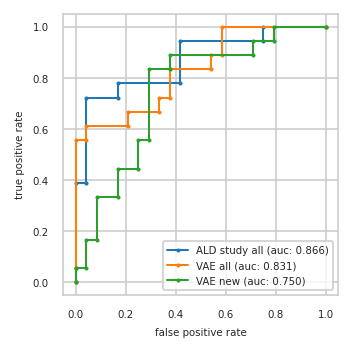

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.000 0.056
2          0.000 0.389   0.000 0.556   0.042 0.056
3          0.042 0.389   0.042 0.556   0.042 0.167
4          0.042 0.722   0.042 0.611   0.083 0.167
5          0.167 0.722   0.208 0.611   0.083 0.333
6          0.167 0.778   0.208 0.667   0.167 0.333
7          0.417 0.778   0.333 0.667   0.167 0.444
8          0.417 0.944   0.333 0.722   0.250 0.444
9          0.750 0.944   0.375 0.722   0.250 0.556
10         0.750 1.000   0.375 0.833   0.292 0.556
11         1.000 1.000   0.542 0.833   0.292 0.833
12           NaN   NaN   0.542 0.889   0.375 0.833
13           NaN   NaN   0.583 0.889   0.375 0.889
14           NaN   NaN   0.583 1.000   0.708 0.889
15           NaN   NaN   1.000 1.000   0.708 0.944
16           NaN   NaN     NaN   NaN   0.792 0.944
17           NaN   NaN     NaN   NaN   0.792 1.000
18           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,F5H265,Q9NX62,Q9UMX0;Q9UMX0-2;Q9UMX0-4
2,Q99969,P08253,Q16799
3,P61981,P14174,P31321
4,P04075,Q9Y2T3;Q9Y2T3-3,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
5,P14174,P61981,P51688
6,P00338;P00338-3,P04075,A0A075B7B8
7,P05160,Q14894,E9PK25;G3V1A4;P23528
8,C9JF17;P05090,P63104,None


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


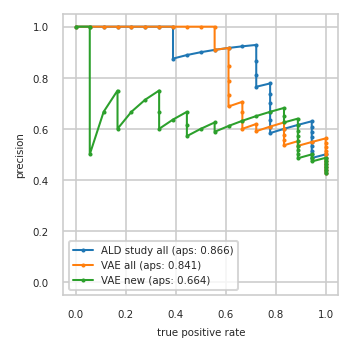

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.486 0.944     0.514 1.000     0.486 0.944
8          0.500 0.944     0.529 1.000     0.500 0.944
9          0.515 0.944     0.545 1.000     0.485 0.889
10         0.531 0.944     0.562 1.000     0.500 0.889
11         0.548 0.944     0.548 0.944     0.516 0.889
12         0.567 0.944     0.533 0.889     0.533 0.889
13         0.586 0.944     0.552 0.889     0.552 0.889
14         0.607 0.944     0.536 0.833     0.571 0.889
15         0.630 0.944     0.556 0.833     0.593 0.889
16         0.615 0.889     0.577 0.833     0.615 0.889
17         0.600 0.833     0.600 0.833     0.640 0.889
18         0.583 0.778     0.625 0.833     0.625 0.833
19         0.609 0.778     0.609 0.778     0.652 0.833
20         0.636 0.778     0.591 0.722     0.682 0.833
21         0.667 0.778     0.619 0.722     0.667 0.778
22         0.700 0.778     0.600 0.667     0.650 0.722
23         0.737 0.778     0.632 0.667     0.632 0.667
24         0.778 0.778     0.667 0.667     0.611 0.611
25         0.765 0.722     0.706 0.667     0.588 0.556
26         0.812 0.722     0.688 0.611     0.625 0.556
27         0.867 0.722     0.733 0.611     0.600 0.500
28         0.929 0.722     0.786 0.611     0.571 0.444
29         0.923 0.667     0.846 0.611     0.615 0.444
30         0.917 0.611     0.917 0.611     0.667 0.444
31         0.909 0.556     0.909 0.556     0.636 0.389
32         0.900 0.500     1.000 0.556     0.600 0.333
33         0.889 0.444     1.000 0.500     0.667 0.333
34         0.875 0.389     1.000 0.444     0.750 0.333
35         1.000 0.389     1.000 0.389     0.714 0.278
36         1.000 0.333     1.000 0.333     0.667 0.222
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


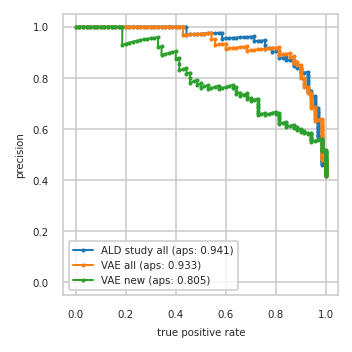

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


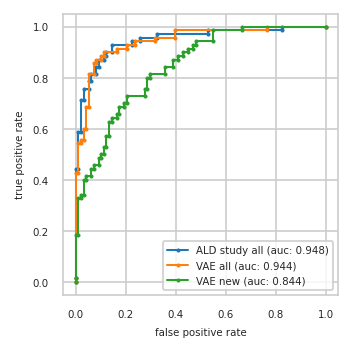

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}